# Projet pratique CIFAR 10 ANN et CNN

 - 60000 image couleur RGB, 32x32 pixels
 - 10 classes d'objets du quotidien , 6000 images par classe
 - Comparaison ANN vs CNN

In [1]:
from keras.datasets import cifar10
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

2025-11-12 09:54:33.166472: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 09:54:33.362189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762937673.437388   14811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762937673.459269   14811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762937673.624133   14811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Chargement automatique et répartition
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# vérification des dimensions
print(f"Train {x_train.shape}, {y_train.shape}")
print(f"Test {x_test.shape}, {y_test.shape}")

Train (50000, 32, 32, 3), (50000, 1)
Test (10000, 32, 32, 3), (10000, 1)


In [22]:
# Dicitonnaire des classes pour l'interpretation

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

## Pipeline de données en Deep Learning

Volume massif, on ne peut pas tout charger en RAM
Uniformisation

Données brutes -> Nettoyage -> Normalisation -> Augmentation -> Batch -> Modèle

In [23]:
# 1. Normalisation simple [0,1]
x_normalized = x_train.astype("float32") / 255.0

# 2. Standardisation Z-score (moyenne=0, écart-type=1)
mean = np.mean(x_train, axis=(0, 1, 2))  # moyenne
std = np.std(x_train, axis=(0, 1, 2))  # ecart-type
x_standardized = (
    x_train - mean
) / std  # x_standardized aura Moyenne = 0 & Écart-type = 1

# 3. Normalisation par canal (ImageNet)
mean_imagenet = [0.485, 0.456, 0.406]  # RGB
std_imagenet = [0.229, 0.224, 0.225]  # RGB

## Augmentation des données

Créer artificiellement de nouvelles images, réduire overfitting, meilleure généralisation 

### Transformation géométriques

In [24]:
# Rotation (-20° à +20°)
rotation_range = 20

# Translation (10% de l'image)
width_shift_range = 0.1
height_shift_range = 0.1

# Zoom (90% à 110%)
zoom_range = 0.1

# Retournement horizontal
horizontal_flip = True

### Transformations photométriques

In [25]:
# Variations de luminosité
brightness_range = [0.8, 1.2]

# Changement de canal (teinte / saturation)
channel_shift_range = 20.0

# Cisaillement (shear)
shear_range = 0.1

### Transformation avec Keras

In [26]:
# Generateur pour l'entrainement (avec augmentation)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisation
    # Transformations
    rotation_range=20,  # Rotation ±20°
    width_shift_range=0.2,  # Translation horizontale
    height_shift_range=0.2,  # Translation verticale
    horizontal_flip=True,  # Flip horizontal
    zoom_range=0.1,  # Zoom ±10%
    fill_mode="nearest",  # Remplissage pixels manquants
)

# Générateur pour validation (sans augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

## Générateurs de données en flux

Traitement par batch, pas tout en RAM

Attention aux paramétres critiques: 

- batch_size (16,32,64,128) 
- shuffle True pour train et False pour val/test
- seed (42)

In [28]:
# Implementation avec flow()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True)

val_generator = val_datagen.flow(x_test, y_test, batch_size=32, shuffle=False)

### Alternative moderne à ImageDataGenerator tf.Data

Natif tensorflow

In [ ]:
def preprocess_image(image, label):
    # normalisation
    image = tf.cast(image, tf.float32) / 255.0

    # augmentation aléatoire
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)

    return image, label


# création du dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


## Validation du pipeline et bonnes pratiques de données

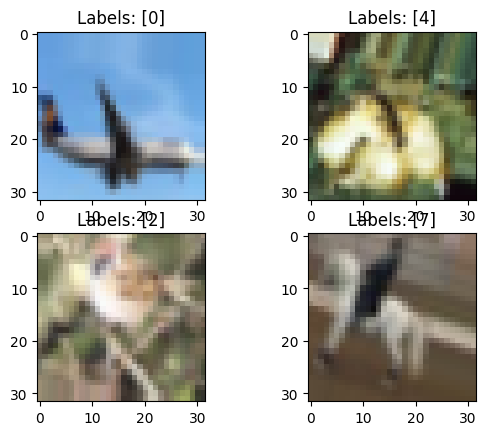

In [30]:
# visualiser les transformations

import matplotlib.pyplot as plt

# Générer un batch d'exemples
batch_images, batch_labels = next(train_generator)

# Afficher les premières images transformées
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(batch_images[i])
    plt.title(f'Labels: {batch_labels[i]}')

## ANN versus CNN

### ANN Dense

In [ ]:
# CIFAR-10: images 32x32x3 = 3072 pixels en entrée

input_shape = (32,32,3)
flattened_input = 32 * 32 * 3 # 3072 neurones d'entrée

In [ ]:
# Couche d'entrée : Flatten (3072 neurones)
# Couche cachée 1 : Dense (512, relu)
# Couche cachée 2 : Dense (256, relu)
# Couche cachée 3 : Dense (128, relu)
# Couche de sortie : Dense (10, softmax) 10 classes

# Attention quasi 2 000 000 paramétres (à cause de la flatten)

### Implémentation ANN avec Keras

In [4]:
def create_ann_model(input_shape=(32,32,3), num_classes=10):
    """_summary_

    Réseau de neurones dense pour classification d'images
    Perte d'information spatiale par aplatissement
    
    Args:
        input_shape (tuple, optional): _description_. Defaults to (32,32,3).
        num_classes (int, optional): _description_. Defaults to 10.
    """
    
    model = Sequential([
        # Conversion image 2D vers 1D
        Flatten(input_shape=input_shape,name='flatten'),
        
        # Première couche cachée
        Dense(512,activation='relu',name='dense_1'),
        Dropout(0.3,name='dropout_1'),
        
        # Deuxième couche cachée
        Dense(256,activation='relu',name='dense_2'),
        Dropout(0.3,name='dropout_2'),
        
        # Troisième couche cachée
        Dense(128,activation='relu',name='dense_3'),
        Dropout(0.3,name='dropout_3'),
        
        # Sortie, classification
        Dense(num_classes,activation='softmax',name='output'),
    ])
    
    return model
    
ann_model = create_ann_model()
print(f'Paramètres ANN: {ann_model.count_params():,}')

Paramètres ANN: 1,738,890


### Conception CNN optimisé

In [8]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """_summary_

    CNN preservation des dimensions spatiales
    Features extraction hiérarchique

    Args:
        input_shape (tuple, optional): _description_. Defaults to (32,32,3).
        num_classes (int, optional): _description_. Defaults to 10.
    """

    model = Sequential(
        [
            # Premier bloc convolutionnel
            Conv2D(
                32, (3, 3), activation="relu", input_shape=input_shape, name="conv2d_1"
            ),
            Conv2D(32, (3, 3), activation="relu", name="conv2d_2"),
            MaxPooling2D((2, 2), name="maxpool_1"),
            Dropout(0.25, name="dropout_1"),
            
            # Deuxième bloc convolutionnel
            Conv2D(64, (3, 3), activation="relu", name="conv2d_3"),
            Conv2D(64, (3, 3), activation="relu", name="conv2d_4"),
            MaxPooling2D((2, 2), name="maxpool_2"),
            Dropout(0.25, name="dropout_2"),
            
            # Troisième bloc convolutionnel
            Conv2D(128, (3, 3), activation="relu", name="conv2d_5"),
            MaxPooling2D((2, 2), name="maxpool_3"),
            Dropout(0.25, name="dropout_3"),
            
            # Classification
            Flatten(name="flatten"),
            Dense(128, activation="relu", name="dense_1"),
            Dropout(0.5, name="dropout_4"),
            Dense(num_classes, activation="softmax", name="output"),
        ]
    )

    return model


cnn_model = create_cnn_model()
print(f"Paramètres CNN: {cnn_model.count_params():,}")

Paramètres CNN: 157,226


/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Configuration et compilation comparative

In [10]:
# Configuration identique pour les deux modèles (équitable)

def compile_models(ann_model, cnn_model):
    compile_config = {
        'optimizer' : Adam(learning_rate=0.001),
        'loss' : SparseCategoricalCrossentropy(from_logits=False),
        'metrics': ['accuracy']
    }
    
    # Compilation des deux modèles
    ann_model.compile(**compile_config)
    cnn_model.compile(**compile_config)
    
    return ann_model, cnn_model

# Application de la configuration
ann_model, cnn_model = compile_models(ann_model=ann_model,cnn_model=cnn_model)

# Affichage des architectures
print("=== ARCHITECTURE ANN ===")
ann_model.summary()

print("=== ARCHITECTURE CNN ===")
cnn_model.summary()

=== ARCHITECTURE ANN ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

=== ARCHITECTURE CNN ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,226 (614.16 KB)

 Trainable params: 157,226 (614.16 KB)

 Non-trainable params: 0 (0.00 B)

ANN : apprend des corrélations pixel par pixel sans structure
CNN : apprend des features visuelles réutilisables

Invariance: CNN robuste aux translations et ANN sensible à la position

CNN moins de paramètres et meilleure accuracy

In [11]:
expected_result = {
    "ANN": {
        "test_accuracy": 0.45, # 45% CIFAR-10
        "convergence_epochs": 35,
        "overfitting": "Important",
        "stability": "Faible",
    },
    "CNN": {
        "test_accuracy": 0.72, # 72% CIFAR-10
        "convergence_epochs": 25,
        "overfitting": "Modéré",
        "Stability": "Bonne",
    },
}